In [0]:
# install keras first
!pip install dill
!pip install -q keras


In [0]:
import os
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=gpu,floatX=float32"


In [0]:
from keras import backend as K
if K.backend()=='tensorflow':
    K.set_image_dim_ordering("th")

In [0]:
batch_size = 256
num_classes = 100
'''
epochs_longrun = 500
save_dir = "/work"
res_dir = "/results"
model_name = 'convnet_cifar100'
'''

In [0]:
from __future__ import print_function
import tensorflow as tf
import keras
from keras.datasets import cifar100
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D
from keras.optimizers import Adam
from keras.layers.pooling import MaxPooling2D
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.utils import to_categorical
from keras.models import load_model

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import *
import warnings
warnings.filterwarnings('ignore')

In [0]:
tf.reset_default_graph()
tf.set_random_seed(343)
np.random.seed(343)
# The data, shuffled and split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar100.load_data()   # point!!!!
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

169009152/169001437 [==============================] - 66s 0us/step


UnpicklingError: ignored

In [0]:
# Convert class vectors to binary class matrices.
y_train_c = to_categorical(y_train, num_classes)
y_test_c = to_categorical(y_test, num_classes)
#Normalize data
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.0    
x_test /= 255.0

In [0]:
# Let's see what values are in the label y_train
np.unique(y_train)   # target is hundred classes

In [0]:
coarse_label = [
'apple', # id 0
'aquarium_fish',
'baby',
'bear',
'beaver',
'bed',
'bee',
'beetle',
'bicycle',
'bottle',
'bowl',
'boy',
'bridge',
'bus',
'butterfly',
'camel',
'can',
'castle',
'caterpillar',
'cattle',
'chair',
'chimpanzee',
'clock',
'cloud',
'cockroach',
'couch',
'crab',
'crocodile',
'cup',
'dinosaur',
'dolphin',
'elephant',
'flatfish',
'forest',
'fox',
'girl',
'hamster',
'house',
'kangaroo',
'computer_keyboard',
'lamp',
'lawn_mower',
'leopard',
'lion',
'lizard',
'lobster',
'man',
'maple_tree',
'motorcycle',
'mountain',
'mouse',
'mushroom',
'oak_tree',
'orange',
'orchid',
'otter',
'palm_tree',
'pear',
'pickup_truck',
'pine_tree',
'plain',
'plate',
'poppy',
'porcupine',
'possum',
'rabbit',
'raccoon',
'ray',
'road',
'rocket',
'rose',
'sea',
'seal',
'shark',
'shrew',
'skunk',
'skyscraper',
'snail',
'snake',
'spider',
'squirrel',
'streetcar',
'sunflower',
'sweet_pepper',
'table',
'tank',
'telephone',
'television',
'tiger',
'tractor',
'train',
'trout',
'tulip',
'turtle',
'wardrobe',
'whale',
'willow_tree',
'wolf',
'woman',
'worm',
]

medium_sized_mammals_index = [ coarse_label.index(x) for x in ['fox', 'porcupine', 'possum', 'raccoon', 'skunk'] ]
small_mammals_index = [ coarse_label.index(x) for x in ['hamster', 'mouse', 'rabbit', 'shrew', 'squirrel'] ]

medium_sized_remaining_mammals_index = [ coarse_label.index(x) for x in ['possum', 'porcupine'] ]
small_remaining_mammals_index = [ coarse_label.index(x) for x in ['mouse', 'hamster'] ]

medium_sized_rest_mammals_index = [ coarse_label.index(x) for x in ['skunk','fox','raccoon'] ]   ###### new
small_rest_mammals_index = [ coarse_label.index(x) for x in ['rabbit','shrew', 'squirrel'] ]  #######new

remaining_mammals_index = medium_sized_remaining_mammals_index + small_remaining_mammals_index
print (medium_sized_mammals_index, small_mammals_index, remaining_mammals_index)

In [0]:
x = np.concatenate((x_train, x_test))
y = np.concatenate((y_train, y_test))

remaining_mammals_slice = np.array([ idx for idx, v in enumerate(y) if v[0] in remaining_mammals_index ])
rest_mammals_slice = np.array([ idx for idx, v in enumerate(y) if v[0] in (set(medium_sized_mammals_index) | set(small_mammals_index)) - set(remaining_mammals_index) ])

x_remaining_mammals = x[remaining_mammals_slice]
y_remaining_mammals = y[remaining_mammals_slice]
y_remaining_mammals_bin = np.array([ [int(y[0] in medium_sized_remaining_mammals_index)] for y in y_remaining_mammals ])

# rest part for "not see animal "test
x_rest_mammals = x[rest_mammals_slice]
y_rest_mammals = y[rest_mammals_slice]
y_rest_mammals_bin = np.array([ [int(y[0] in medium_sized_rest_mammals_index)] for y in y_rest_mammals ])   ####new
print(y_rest_mammals_bin)

print (x_remaining_mammals.shape, y_remaining_mammals.shape)
print (x_rest_mammals.shape, y_rest_mammals.shape)
print (y_remaining_mammals_bin.shape, y_rest_mammals_bin.shape)

from sklearn.model_selection import train_test_split

# the data will work on 
x_remaining_mammals_train, x_remaining_mammals_test, y_remaining_mammals_train, y_remaining_mammals_test = \
  train_test_split(x_remaining_mammals, y_remaining_mammals_bin, test_size=0.2, random_state=42)

print (x_remaining_mammals_train.shape, x_remaining_mammals_test.shape)
print (y_remaining_mammals_train.shape, y_remaining_mammals_test.shape)

In [0]:
# ten classes label
target_label = {34: 'fox', 63: 'porcupine', 64: 'possum', 66: 'raccoon', 75: 'skunk', 36: 'hamster', 50: 'mouse', 65: 'rabbit', 74: 'shrew', 80: 'squirrel'}

In [0]:
small_mammals = ['hamster', 'mouse', 'rabbit', 'shrew', 'squirrel']
medium_sized_mammals = ['fox', 'porcupine', 'possum', 'raccoon', 'skunk']

In [0]:
def cifar_grid2(X,Y,inds,n_col,predictions):  #print out randomly selected images and their labels  
  N = len(inds)
  n_row = int(ceil(1.0*N/n_col))
  fig = plt.figure(figsize=(15, 20))
  #count=0
  #l=list()
# align labels in the right order  #encode the target class
  clabels = ['small_mammals','medium_sized_mammal']
  #print(type(clabels))
  for j in range(n_row):
    for k in range(n_col):
      i_inds = (j*n_col)+k
      i_data = inds[i_inds]
     
      if i_inds < N:
        rgb = X[[i_data,...]]
        #test_label=test_list[0] if clabels[Y[i_data][0]]=='small_mammals' else test_list[1]  
        label =clabels[Y[i_data][0]]
        img = rgb.reshape(3,32,32).transpose([1, 2, 0])
        fig.add_subplot(n_row,n_col, i_inds+1)
        #pred = clabels[np.argmax(predictions[i_data,...])]
        pred = clabels[predictions[i_data]]
        plt.imshow(img, interpolation='nearest')
        plt.title("actual: {}\n predict: {}".format(label,pred))  
        #if label==pred:
        #  count+=1
        #  l.append(j*4+k)
  #print(count)
  #print(l)
         
  fig.set_tight_layout(True)

In [0]:
# choose 36 img randomly
indices = [np.random.choice(range(len(y_remaining_mammals_test))) for i in range(36)]
print (indices)

#cifar_grid(x_train,y_train_bin,indices,1,prediction)

# **Loop (CHING-MIN)**

In [0]:
# select two from each superclass
def select_two(mammals_list):
  mammals_two=list()
  for i in range(0,5):
    for j in range(i+1,5):
      mammals_two.append([mammals_list[i],mammals_list[j]])
  return mammals_two

In [0]:
small_two=select_two(small_mammals)
medium_two=select_two(medium_sized_mammals)
#len(medium_two)

In [0]:
def train_test_2(small,medium): # test class for small and med
  small_mammals = ['hamster', 'mouse', 'rabbit', 'shrew', 'squirrel']
  small_mammals.remove(small[0])
  small_mammals.remove(small[1])
  medium_sized_mammals = ['fox', 'porcupine', 'possum', 'raccoon', 'skunk']
  medium_sized_mammals.remove(medium[0])
  medium_sized_mammals.remove(medium[1])
  
  # For training set
  medium_ind = [ coarse_label.index(x) for x in medium_sized_mammals ]
  small_ind = [ coarse_label.index(x) for x in small_mammals ]
  target_ind = medium_ind + small_ind

  #print ("Training set-\nNew index of Medium-sized mammals:", medium_ind,"\nNew index of Small mammals:", small_ind)

  # For testing data - 
  medium_ind_2 = [ coarse_label.index(x) for x in medium ]
  small_ind_2 = [ coarse_label.index(x) for x in small ]
  target_ind_2 = medium_ind_2 + small_ind_2
  #print ("\nTesting set-\nNew index of Medium-sized mammals:", medium_ind_2,"\nNew index of Small mammals:", small_ind_2)
  
  # Splice the dataset to extract the relevant portion of data
  train_slice3 = np.array([ idx for idx, y in enumerate(y) if y[0] in target_ind])
  y_train4 = y[train_slice3]
  x_train4 = x[train_slice3]

  # Test set
  test_slice3 = np.array([ idx for idx, y in enumerate(y) if y[0] in target_ind_2])
  y_test4 = y[test_slice3]
  x_test4 = x[test_slice3]

  #print ("Training set:", np.unique(y_train4))
  #print ("\nTesting set:", np.unique(y_test4))
  #  Binary as we are working with two superclasses labels (or coarse labels)
  y_train_bin4 = np.array([[int(y[0] in medium_ind)] for y in y_train4])
  y_test_bin4 = np.array([[int(y[0] in medium_ind_2)] for y in y_test4])
  y_bin4 = np.concatenate((y_train_bin4,y_test_bin4)) # for two superclass
  
  return x_train4,x_test4,y_train_bin4,y_test_bin4

In [0]:
# create list for train and test
# train,test=test,train
x_train5=list()
x_test5=list()
y_train_bin5=list()
y_test_bin5=list()
train_list=list()  
for i in range(0,10):
  for j in range(0,10):
    small=small_two[i]
    medium=medium_two[j]
    x_test_temp,x_train_temp,y_test_temp,y_train_temp=train_test_2(small,medium)
    x_train5.append(x_train_temp)
    x_test5.append(x_test_temp)
    y_train_bin5.append(y_train_temp)
    y_test_bin5.append(y_test_temp)
    train_list.append([small,medium])  


In [0]:
x_train5_ = [x_train5[i].reshape(x_train5[i].shape[0],3*32*32) for i in range(0,100)]
x_test5_ = [x_test5[i].reshape(x_test5[i].shape[0],3*32*32) for i in range(0,100)]
len(x_train5_)

100

100 trials:

x_train5_

x_test5_

y_train_bin5

y_test_bin5

In [0]:
"""import time
from sklearn.ensemble import BaggingClassifier
start = time.time()
bag = BaggingClassifier()
bag.fit(x_train5_[0], y_train_bin5[0])
bag_pred=bag.predict(x_test5_[0])
print ("Accuracy ({}, {}): {}%".format(train_list[0][0],train_list[0][1] ,bag.score(x_test5_[0], y_test_bin5[0])*100)) 
end = time.time()"""

Accuracy (['hamster', 'mouse'], ['fox', 'porcupine']): 51.138888888888886%


# **Machine Learning Algorithms (Dandan and CHING-MIN)**

In [0]:
import time
#Let's see how good is RandomForest
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# reshape
x_remaining_mammals_train = x_remaining_mammals_train.reshape(x_remaining_mammals_train.shape[0],3*32*32)

x_remaining_mammals_test = x_remaining_mammals_test.reshape(x_remaining_mammals_test.shape[0],3*32*32)

x_rest_mammals = x_rest_mammals.reshape(x_rest_mammals.shape[0], 3*32*32)

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.model_selection import cross_val_score

# **Random Forest**

In [0]:
# find the baseline performance for the random Forest
start = time.time()
logit = RandomForestClassifier()
logit.fit(x_remaining_mammals_train, y_remaining_mammals_train)
logit_pred=logit.predict(x_rest_mammals)
scores = cross_val_score(logit, x_remaining_mammals_train,y_remaining_mammals_train, cv=5)
print(scores)
print ("RandomForest Accuracy: {}%".format(logit.score(x_remaining_mammals_test, y_remaining_mammals_test)*100))
print ("RandomForest Accuracy: {}%".format(logit.score(x_rest_mammals, y_rest_mammals_bin)*100))
end = time.time()
print(end - start)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was

[0.71168831 0.68831169 0.69270833 0.70234987 0.70496084]
RandomForest Accuracy: 68.75%
RandomForest Accuracy: 52.22222222222223%
3.196669340133667


# **Random Forest with tuning the Parameters**

In [0]:
tuned_parameters = {'n_estimators': range(10,100,20), 'max_depth': range(2,20,5)}

In [0]:
%%time
logit = GridSearchCV(RandomForestClassifier(), tuned_parameters, cv=3, n_jobs = -1, verbose=0)
logit.fit(x_remaining_mammals_train, y_remaining_mammals_train)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:740: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


CPU times: user 4.57 s, sys: 128 ms, total: 4.7 s
Wall time: 1min 6s


In [0]:
print("Best parameters set found on development set:")
print()
print(logit.best_params_)
print()
print("Grid scores on development set:")
print()
means = logit.cv_results_['mean_test_score']
stds = logit.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, logit.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

Best parameters set found on development set:

{'max_depth': 17, 'n_estimators': 70}

Grid scores on development set:

0.689 (+/-0.028) for {'max_depth': 2, 'n_estimators': 10}
0.703 (+/-0.026) for {'max_depth': 2, 'n_estimators': 30}
0.697 (+/-0.014) for {'max_depth': 2, 'n_estimators': 50}
0.699 (+/-0.028) for {'max_depth': 2, 'n_estimators': 70}
0.710 (+/-0.029) for {'max_depth': 2, 'n_estimators': 90}
0.696 (+/-0.010) for {'max_depth': 7, 'n_estimators': 10}
0.706 (+/-0.052) for {'max_depth': 7, 'n_estimators': 30}
0.722 (+/-0.038) for {'max_depth': 7, 'n_estimators': 50}
0.728 (+/-0.043) for {'max_depth': 7, 'n_estimators': 70}
0.718 (+/-0.035) for {'max_depth': 7, 'n_estimators': 90}
0.692 (+/-0.051) for {'max_depth': 12, 'n_estimators': 10}
0.716 (+/-0.049) for {'max_depth': 12, 'n_estimators': 30}
0.728 (+/-0.047) for {'max_depth': 12, 'n_estimators': 50}
0.715 (+/-0.013) for {'max_depth': 12, 'n_estimators': 70}
0.725 (+/-0.038) for {'max_depth': 12, 'n_estimators': 90}
0.701 

In [0]:
print ('prediction score on testing data with the best estimator: %.2f%%' % (logit.best_estimator_.score(x_remaining_mammals_test, y_remaining_mammals_test)*100))
print ('prediction score on testing data with the best estimator: %.2f%%' % (logit.best_estimator_.score(x_remaining_mammals_train, y_remaining_mammals_train)*100))
print ('prediction score on testing data with the best estimator: %.2f%%' % (logit.best_estimator_.score(x_rest_mammals, y_rest_mammals_bin)*100))

prediction score on testing data with the best estimator: 73.96%
prediction score on testing data with the best estimator: 100.00%
prediction score on testing data with the best estimator: 53.17%


/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


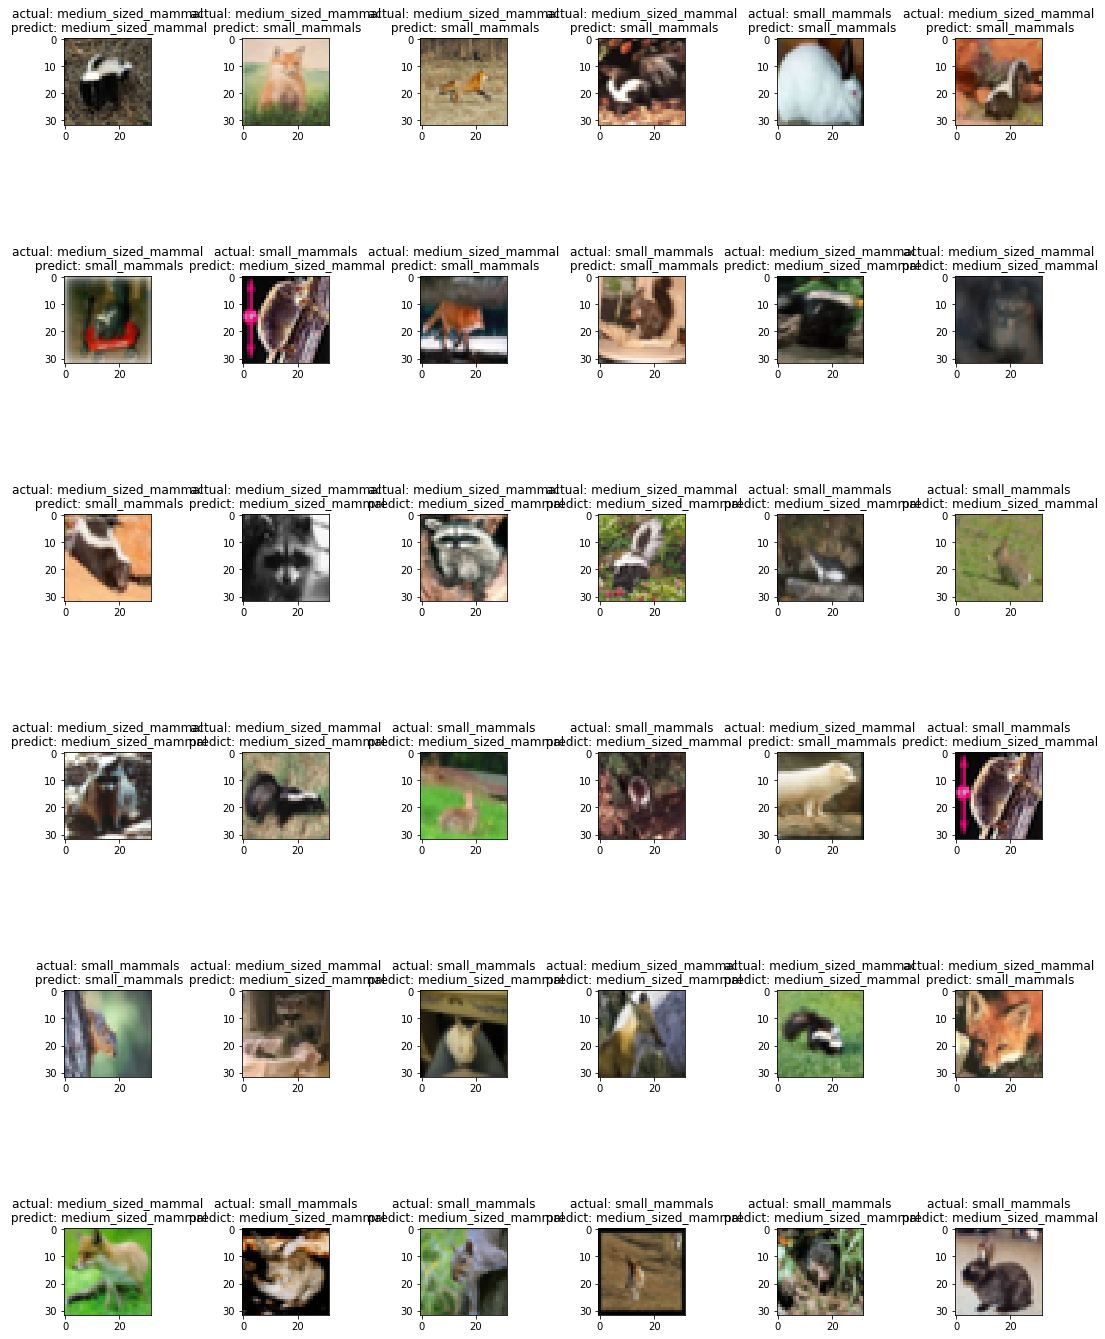

In [0]:
logit_pred=logit.predict(x_rest_mammals)
indices = [np.random.choice(range(len(x_rest_mammals))) for j in range(36)]
cifar_grid2(x_rest_mammals, y_rest_mammals_bin, indices,6,logit_pred)

In [0]:
print(confusion_matrix(y_rest_mammals_bin, logit_pred, labels=None, sample_weight=None))

[[ 705 1095]
 [ 591 1209]]


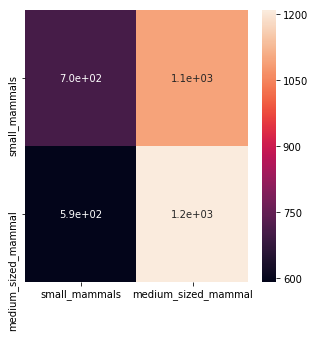

In [0]:
cm=confusion_matrix(y_rest_mammals_bin, logit_pred, labels=[0,1], sample_weight=None)
plt.figure(figsize = (5,5))
df_cm = pd.DataFrame(cm, index = [i for i in ['small_mammals','medium_sized_mammal']],
                  columns = [i for i in ['small_mammals','medium_sized_mammal']])

ax=sns.heatmap(df_cm, annot=True)

In [0]:
print (classification_report(y_rest_mammals_bin, logit_pred))

              precision    recall  f1-score   support

           0       0.54      0.39      0.46      1800
           1       0.52      0.67      0.59      1800

   micro avg       0.53      0.53      0.53      3600
   macro avg       0.53      0.53      0.52      3600
weighted avg       0.53      0.53      0.52      3600



# **Extra Decison Tree**

In [0]:
# train extra decision tree with default parameters
start = time.time()
Extratree = ExtraTreesClassifier()
Extratree.fit(x_remaining_mammals_train, y_remaining_mammals_train)
Extratree_pred=Extratree.predict(x_rest_mammals)
scores = cross_val_score(Extratree, x_remaining_mammals_train, y_remaining_mammals_train, cv=5)
print ("ExtraTree Accuracy: {}%".format(Extratree.score(x_remaining_mammals_test, y_remaining_mammals_test)*100))
print ("ExtraTree Accuracy: {}%".format(Extratree.score(x_rest_mammals, y_rest_mammals_bin)*100))
end = time.time()
print(end - start)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was

ExtraTree Accuracy: 71.04166666666667%
ExtraTree Accuracy: 52.13888888888889%
1.3518385887145996


In [0]:
tuned_parameters = {'n_estimators': range(10,100,20), 'max_depth': range(2,20,5)}

In [0]:
%%time
Extratree = GridSearchCV(ExtraTreesClassifier(bootstrap = True), tuned_parameters, cv=5, verbose=0)
Extratree.fit(x_rest_mammals, y_rest_mammals_bin)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 

CPU times: user 1min 35s, sys: 77.9 ms, total: 1min 35s
Wall time: 1min 35s


In [0]:
print("Best parameters set found on development set:")
print()
print(Extratree.best_params_)
print()
print("Grid scores on development set:")
print()
means = Extratree.cv_results_['mean_test_score']
stds = Extratree.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, Extratree.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

Best parameters set found on development set:

{'max_depth': 17, 'n_estimators': 90}

Grid scores on development set:

0.624 (+/-0.024) for {'max_depth': 2, 'n_estimators': 10}
0.614 (+/-0.032) for {'max_depth': 2, 'n_estimators': 30}
0.607 (+/-0.032) for {'max_depth': 2, 'n_estimators': 50}
0.609 (+/-0.032) for {'max_depth': 2, 'n_estimators': 70}
0.609 (+/-0.029) for {'max_depth': 2, 'n_estimators': 90}
0.641 (+/-0.026) for {'max_depth': 7, 'n_estimators': 10}
0.658 (+/-0.035) for {'max_depth': 7, 'n_estimators': 30}
0.664 (+/-0.029) for {'max_depth': 7, 'n_estimators': 50}
0.669 (+/-0.034) for {'max_depth': 7, 'n_estimators': 70}
0.662 (+/-0.035) for {'max_depth': 7, 'n_estimators': 90}
0.633 (+/-0.024) for {'max_depth': 12, 'n_estimators': 10}
0.666 (+/-0.039) for {'max_depth': 12, 'n_estimators': 30}
0.682 (+/-0.039) for {'max_depth': 12, 'n_estimators': 50}
0.683 (+/-0.034) for {'max_depth': 12, 'n_estimators': 70}
0.687 (+/-0.039) for {'max_depth': 12, 'n_estimators': 90}
0.618 

In [0]:
print ('prediction score on testing data with the best estimator: %.2f%%' % (Extratree.best_estimator_.score(x_remaining_mammals_test, y_remaining_mammals_test)*100))
print ('prediction score on testing data with the best estimator: %.2f%%' % (Extratree.best_estimator_.score(x_rest_mammals, y_rest_mammals_bin)*100))

prediction score on testing data with the best estimator: 58.54%
prediction score on testing data with the best estimator: 99.97%


/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


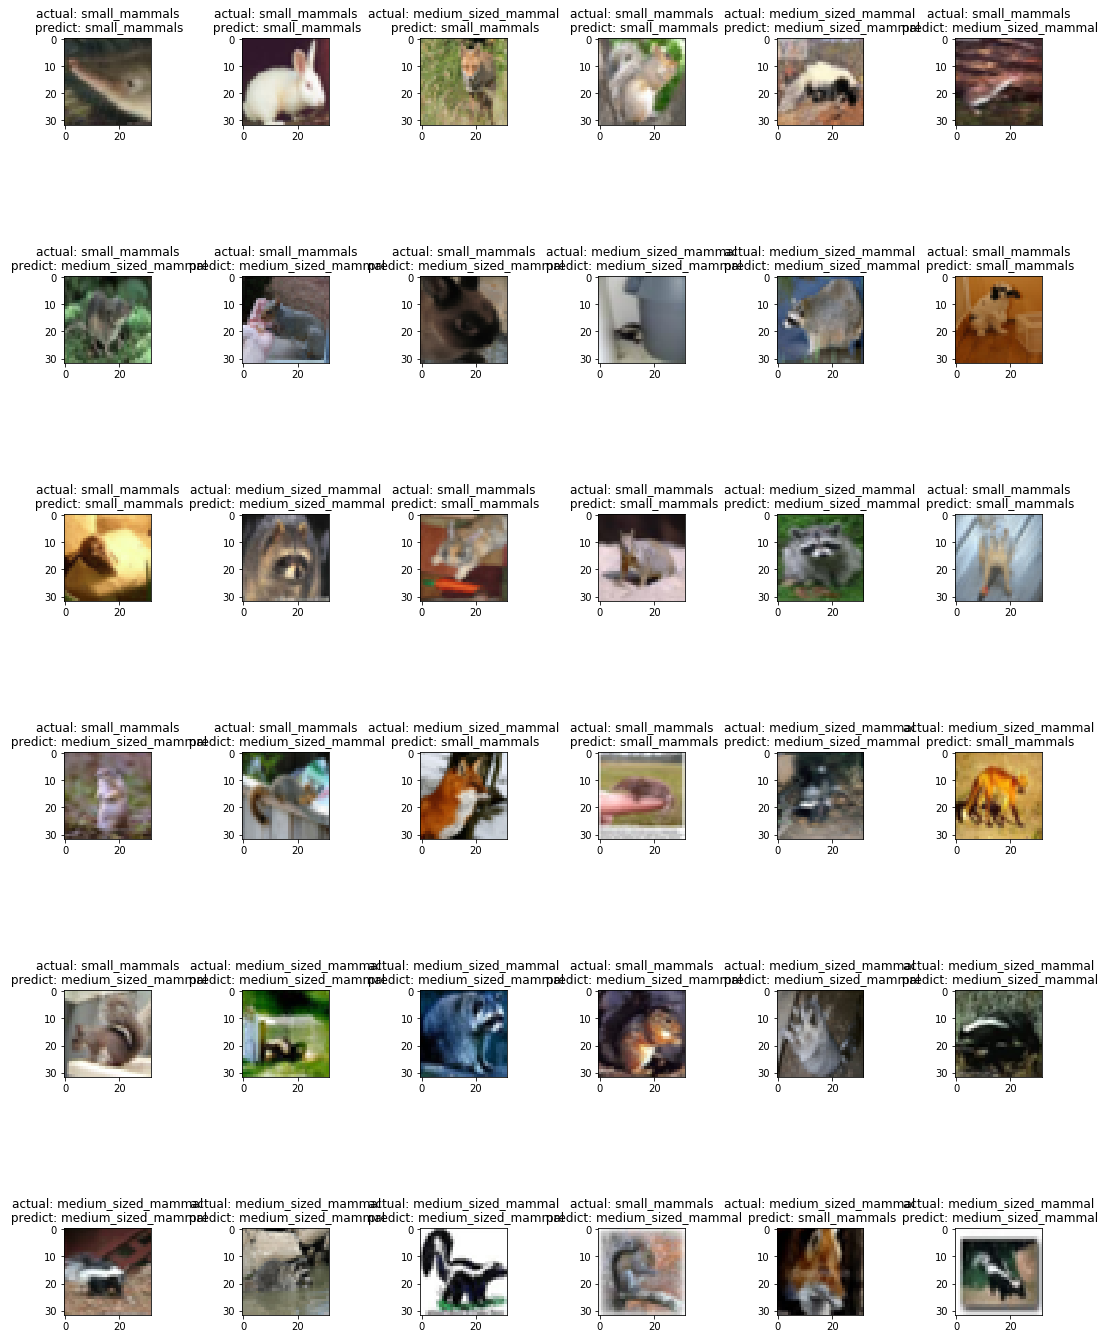

In [0]:
indices = [np.random.choice(range(len(x_rest_mammals))) for j in range(36)]
cifar_grid2(x_rest_mammals, y_rest_mammals_bin, indices,6,logit_pred)

In [0]:
print(confusion_matrix(y_rest_mammals_bin, Extratree_pred, labels=None, sample_weight=None))

[[888 912]
 [811 989]]


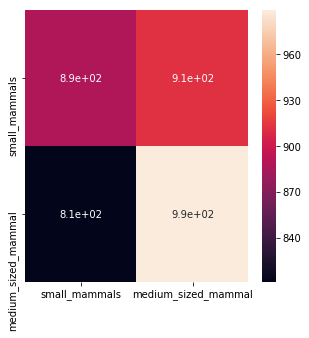

In [0]:
cm=confusion_matrix(y_rest_mammals_bin, Extratree_pred, labels=[0,1], sample_weight=None)
plt.figure(figsize = (5,5))
df_cm = pd.DataFrame(cm, index = [i for i in ['small_mammals','medium_sized_mammal']],
                  columns = [i for i in ['small_mammals','medium_sized_mammal']])

ax=sns.heatmap(df_cm, annot=True)

In [0]:
print (classification_report(y_rest_mammals_bin, Extratree_pred))

              precision    recall  f1-score   support

           0       0.52      0.49      0.51      1800
           1       0.52      0.55      0.53      1800

   micro avg       0.52      0.52      0.52      3600
   macro avg       0.52      0.52      0.52      3600
weighted avg       0.52      0.52      0.52      3600



# **KNN**

In [0]:
# default
# find the baseline performance for the knn
start = time.time()
knn = KNeighborsClassifier()
knn.fit(x_remaining_mammals, y_remaining_mammals_bin)
knn_pred=knn.predict(x_rest_mammals)
scores = cross_val_score(knn, x_remaining_mammals,y_remaining_mammals_bin, cv=5)
print(scores)
scores = cross_val_score(knn, x_rest_mammals,y_rest_mammals_bin, cv=5)
print(scores)
print ("KNN Accuracy: {}%".format(knn.score(x_remaining_mammals, y_remaining_mammals_bin)*100))
print ("KNN Accuracy: {}%".format(knn.score(x_rest_mammals, y_rest_mammals_bin)*100))
end = time.time()
print(end - start)

[0.70416667 0.71666667 0.68958333 0.71875    0.6625    ]
[0.59583333 0.55694444 0.575      0.5875     0.56666667]
KNN Accuracy: 79.70833333333334%
KNN Accuracy: 53.13888888888889%
289.59020948410034


## **find the best peremeter**

In [0]:
for a in [1,2,3]:
  for b in ['uniform','distance']:
    print('n_neighbors: {}, weights: {}'.format(a,b))
    knn_clf = KNeighborsClassifier(n_neighbors=a, weights=b)
    knn_clf.fit(x_remaining_mammals, y_remaining_mammals_bin)
    scores = cross_val_score(knn_clf, x_remaining_mammals,y_remaining_mammals, cv=5)
    print(scores)
    print ("KNN Accuracy: {}%\n".format(knn_clf.score(x_rest_mammals, y_rest_mammals_bin)*100))

n_neighbors: 1, weights: uniform
[0.4875     0.51458333 0.50208333 0.5        0.45208333]
KNN Accuracy: 51.30555555555556%

n_neighbors: 1, weights: distance
[0.4875     0.51458333 0.50208333 0.5        0.45208333]
KNN Accuracy: 51.30555555555556%

n_neighbors: 2, weights: uniform
[0.46875    0.46875    0.475      0.47708333 0.4625    ]
KNN Accuracy: 52.30555555555556%

n_neighbors: 2, weights: distance
[0.4875     0.51458333 0.50208333 0.5        0.45208333]
KNN Accuracy: 51.30555555555556%

n_neighbors: 3, weights: uniform
[0.45       0.49791667 0.50625    0.5        0.4625    ]
KNN Accuracy: 53.11111111111111%

n_neighbors: 3, weights: distance
[0.46458333 0.51041667 0.49375    0.525      0.47083333]
KNN Accuracy: 53.11111111111111%



In [0]:
for a in [4,5,6]:
  for b in ['uniform','distance']:
    print('n_neighbors: {}, weights: {}'.format(a,b))
    knn_clf = KNeighborsClassifier(n_neighbors=a, weights=b)
    knn_clf.fit(x_remaining_mammals, y_remaining_mammals_bin)
    scores = cross_val_score(knn_clf, x_remaining_mammals,y_remaining_mammals, cv=5)
    print(scores)
    print ("KNN Accuracy: {}%\n".format(knn_clf.score(x_rest_mammals, y_rest_mammals_bin)*100))

n_neighbors: 4, weights: uniform
[0.45625    0.49166667 0.49583333 0.49583333 0.46041667]
KNN Accuracy: 53.388888888888886%

n_neighbors: 4, weights: distance
[0.47291667 0.51458333 0.51666667 0.51458333 0.47291667]
KNN Accuracy: 52.861111111111114%

n_neighbors: 5, weights: uniform
[0.44583333 0.50416667 0.50416667 0.51875    0.46666667]
KNN Accuracy: 53.13888888888889%

n_neighbors: 5, weights: distance
[0.46041667 0.54375    0.50208333 0.525      0.45416667]
KNN Accuracy: 53.13888888888889%

n_neighbors: 6, weights: uniform
[0.48333333 0.50416667 0.47291667 0.49583333 0.45833333]
KNN Accuracy: 53.55555555555556%

n_neighbors: 6, weights: distance
[0.47083333 0.53125    0.49375    0.51666667 0.46666667]
KNN Accuracy: 53.75%



In [0]:
for a in [7,8,9]:
  for b in ['uniform','distance']:
    print('n_neighbors: {}, weights: {}'.format(a,b))
    knn_clf = KNeighborsClassifier(n_neighbors=a, weights=b)
    knn_clf.fit(x_remaining_mammals, y_remaining_mammals_bin)
    scores = cross_val_score(knn_clf, x_remaining_mammals,y_remaining_mammals, cv=5)
    print(scores)
    print ("KNN Accuracy: {}%\n".format(knn_clf.score(x_rest_mammals, y_rest_mammals_bin)*100))

n_neighbors: 7, weights: uniform
[0.45833333 0.50833333 0.47708333 0.51458333 0.46041667]
KNN Accuracy: 53.41666666666667%

n_neighbors: 7, weights: distance
[0.47708333 0.52916667 0.5        0.52708333 0.45      ]
KNN Accuracy: 53.41666666666667%

n_neighbors: 8, weights: uniform
[0.46458333 0.49375    0.47916667 0.51458333 0.4375    ]
KNN Accuracy: 53.69444444444444%

n_neighbors: 8, weights: distance
[0.46875    0.53541667 0.50833333 0.52916667 0.4375    ]
KNN Accuracy: 53.63888888888889%

n_neighbors: 9, weights: uniform
[0.48958333 0.51041667 0.50416667 0.5125     0.46458333]
KNN Accuracy: 53.5%

n_neighbors: 9, weights: distance
[0.48125    0.52291667 0.51041667 0.53333333 0.45      ]
KNN Accuracy: 53.5%



In [0]:
for a in [10,20,50]:
  for b in ['uniform','distance']:
    print('n_neighbors: {}, weights: {}'.format(a,b))
    knn_clf = KNeighborsClassifier(n_neighbors=a, weights=b)
    knn_clf.fit(x_remaining_mammals, y_remaining_mammals_bin)
    scores = cross_val_score(knn_clf, x_remaining_mammals,y_remaining_mammals, cv=5)
    print(scores)
    print ("KNN Accuracy: {}%\n".format(knn_clf.score(x_rest_mammals, y_rest_mammals_bin)*100))

n_neighbors: 10, weights: uniform
[0.45       0.51666667 0.475      0.51041667 0.45208333]
KNN Accuracy: 53.63888888888889%

n_neighbors: 10, weights: distance
[0.45625    0.53125    0.5        0.52708333 0.4375    ]
KNN Accuracy: 53.61111111111111%

n_neighbors: 20, weights: uniform
[0.46666667 0.4875     0.48125    0.50833333 0.46458333]
KNN Accuracy: 53.47222222222222%

n_neighbors: 20, weights: distance
[0.47291667 0.49166667 0.48958333 0.51666667 0.4625    ]
KNN Accuracy: 52.97222222222222%

n_neighbors: 50, weights: uniform
[0.46875    0.48958333 0.4625     0.5        0.47291667]
KNN Accuracy: 53.30555555555555%

n_neighbors: 50, weights: distance
[0.47708333 0.5        0.46041667 0.49583333 0.475     ]
KNN Accuracy: 53.44444444444445%



In [0]:
for a in [100,200,500,1000]:
  for b in ['uniform','distance']:
    print('n_neighbors: {}, weights: {}'.format(a,b))
    knn_clf = KNeighborsClassifier(n_neighbors=a, weights=b)
    knn_clf.fit(x_remaining_mammals, y_remaining_mammals_bin)
    scores = cross_val_score(knn_clf, x_remaining_mammals,y_remaining_mammals, cv=5)
    print(scores)
    print ("KNN Accuracy: {}%\n".format(knn_clf.score(x_rest_mammals, y_rest_mammals_bin)*100))

n_neighbors: 100, weights: uniform
[0.4625     0.45416667 0.46041667 0.475      0.44375   ]
KNN Accuracy: 52.916666666666664%

n_neighbors: 100, weights: distance
[0.46875    0.45833333 0.46458333 0.47083333 0.43958333]
KNN Accuracy: 52.80555555555555%

n_neighbors: 200, weights: uniform
[0.4375     0.425      0.43541667 0.42291667 0.42083333]
KNN Accuracy: 53.11111111111111%

n_neighbors: 200, weights: distance
[0.43958333 0.43125    0.43958333 0.42916667 0.42291667]
KNN Accuracy: 53.11111111111111%

n_neighbors: 500, weights: uniform
[0.39375    0.4        0.42083333 0.40833333 0.40208333]
KNN Accuracy: 52.25%

n_neighbors: 500, weights: distance
[0.39791667 0.41458333 0.43333333 0.41041667 0.40833333]
KNN Accuracy: 52.30555555555556%

n_neighbors: 1000, weights: uniform
[0.41875    0.38541667 0.40833333 0.41458333 0.38333333]
KNN Accuracy: 52.416666666666664%

n_neighbors: 1000, weights: distance
[0.43333333 0.39791667 0.45416667 0.40625    0.40833333]
KNN Accuracy: 52.4722222222222

## **best peremeter**

In [0]:
start = time.time()
knn = KNeighborsClassifier(n_neighbors=6,weights='distance')
knn.fit(x_remaining_mammals, y_remaining_mammals_bin)
knn_pred=knn.predict(x_rest_mammals)
#scores = cross_val_score(knn, x_remaining_mammals,y_remaining_mammals_bin, cv=5)
#print(scores)
#scores = cross_val_score(knn, x_rest_mammals,y_rest_mammals_bin, cv=5)
#print(scores)
print ("KNN Accuracy: {}%".format(knn.score(x_remaining_mammals, y_remaining_mammals_bin)*100))
print ("KNN Accuracy: {}%".format(knn.score(x_rest_mammals, y_rest_mammals_bin)*100))
end = time.time()
print(end - start)

KNN Accuracy: 100.0%
KNN Accuracy: 53.75%
175.40930438041687


In [0]:
indices = [np.random.choice(range(len(x_rest_mammals))) for i in range(36)]

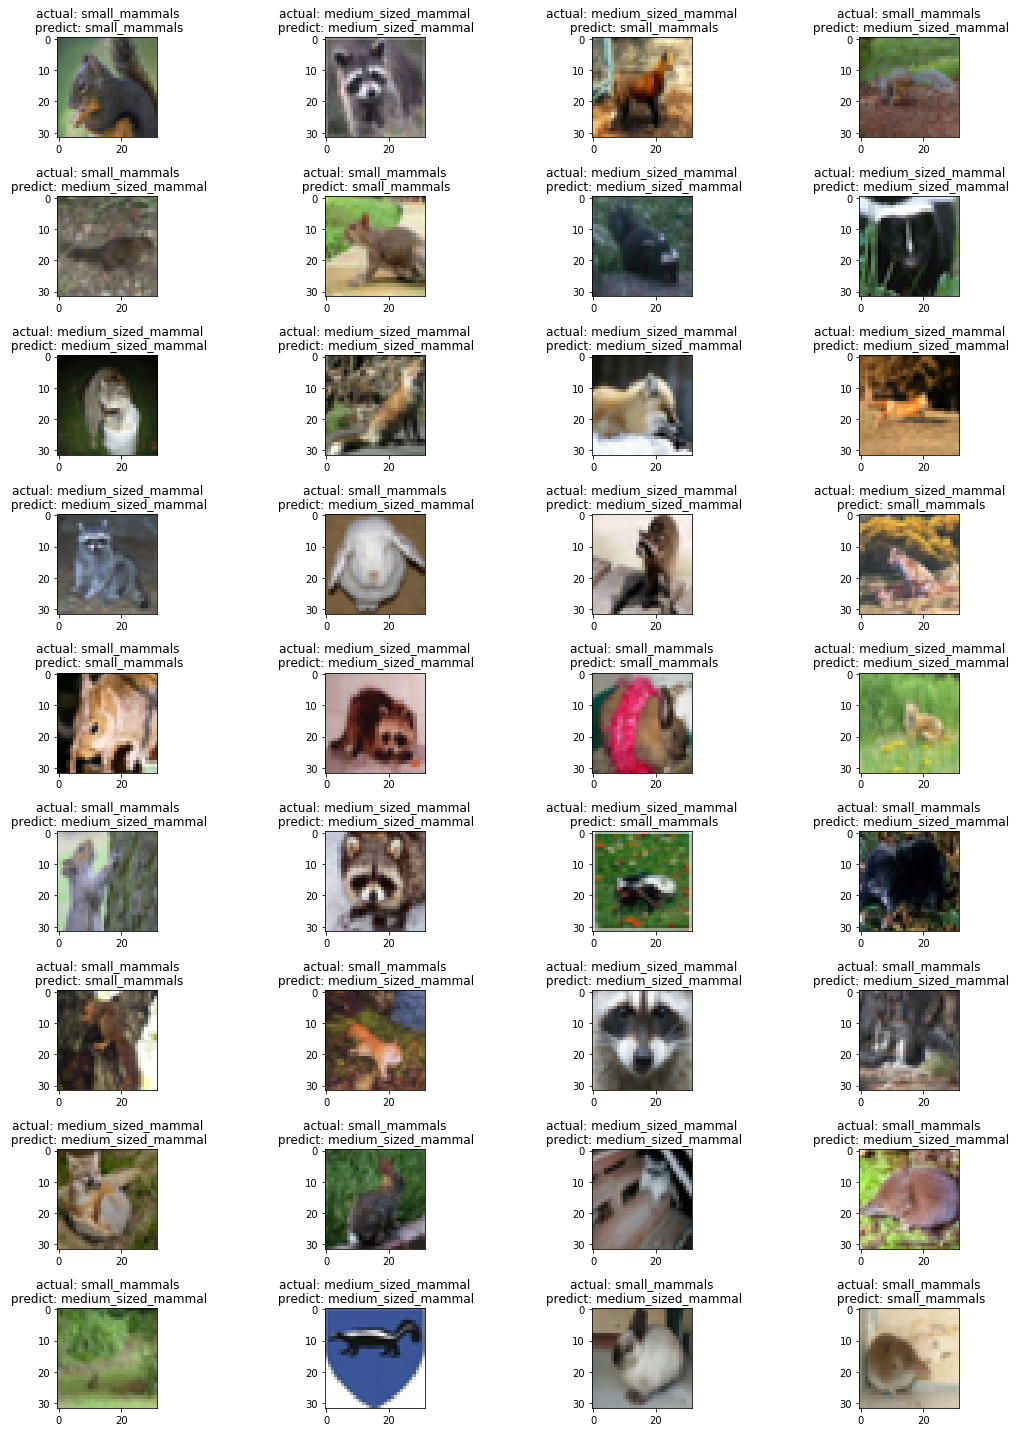

In [0]:
cifar_grid2(x_rest_mammals,y_rest_mammals_bin,indices,4,knn_pred)

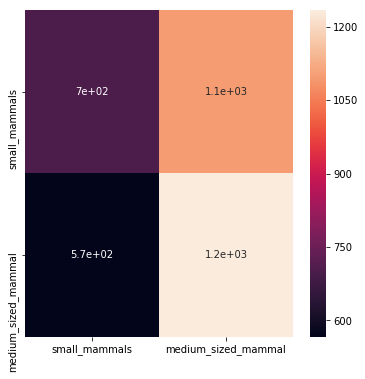

In [0]:
cm=confusion_matrix(y_rest_mammals_bin, knn_pred, labels=[0,1], sample_weight=None)
plt.figure(figsize = (6,6))
df_cm = pd.DataFrame(cm, index = [i for i in ['small_mammals','medium_sized_mammal']],
                  columns = [i for i in ['small_mammals','medium_sized_mammal']])

ax=sns.heatmap(df_cm, annot=True)

In [0]:
print(classification_report(y_rest_mammals_bin, knn_pred,target_names=['small_mammals','medium_sized_mammal']))

                     precision    recall  f1-score   support

      small_mammals       0.55      0.39      0.46      1800
medium_sized_mammal       0.53      0.69      0.60      1800

          micro avg       0.54      0.54      0.54      3600
          macro avg       0.54      0.54      0.53      3600
       weighted avg       0.54      0.54      0.53      3600



In [0]:
knn_accuracy3=list()
knn_time3=list()
print("KNN ") 
for i in range(0,100):
  start = time.time()
  knn1 = KNeighborsClassifier(n_neighbors=6, weights='distance')
  knn1.fit(x_train5_[i], y_train_bin5[i])
  #knn1_pred=knn1.predict(x_test5_[i])
  print ("Accuracy ({}, {}): {}%".format(train_list[i][0],train_list[i][1] ,knn1.score(x_test5_[i], y_test_bin5[i])*100)) 
  end = time.time()
  print('{} seconds\n'.format(end - start))
  knn_accuracy3.append(knn1.score(x_test5_[i], y_test_bin5[i]))
  knn_time3.append(end-start)
  # choose 36 img randomly
  #indices = [np.random.choice(range(len(x_test3_[i]))) for j in range(36)]
  #cifar_grid1(x_test3_[i], y_test_bin3[i], indices,4,lr_pred)
print("average accuracy: {}%".format(np.mean(knn_accuracy3)*100))
print("average time: {} seconds".format(np.mean(knn_time3)))

KNN 
Accuracy (['hamster', 'mouse'], ['fox', 'porcupine']): 55.19444444444444%
67.9418613910675 seconds

Accuracy (['hamster', 'mouse'], ['fox', 'possum']): 54.44444444444444%
67.55032849311829 seconds

Accuracy (['hamster', 'mouse'], ['fox', 'raccoon']): 54.13888888888889%
68.25186467170715 seconds

Accuracy (['hamster', 'mouse'], ['fox', 'skunk']): 52.11111111111111%
66.21036076545715 seconds

Accuracy (['hamster', 'mouse'], ['porcupine', 'possum']): 53.75%
66.2989912033081 seconds

Accuracy (['hamster', 'mouse'], ['porcupine', 'raccoon']): 52.72222222222223%
66.31367254257202 seconds

Accuracy (['hamster', 'mouse'], ['porcupine', 'skunk']): 52.361111111111114%
66.77315402030945 seconds

Accuracy (['hamster', 'mouse'], ['possum', 'raccoon']): 52.361111111111114%
67.31018710136414 seconds

Accuracy (['hamster', 'mouse'], ['possum', 'skunk']): 51.30555555555556%
66.90391445159912 seconds

Accuracy (['hamster', 'mouse'], ['raccoon', 'skunk']): 51.30555555555556%
67.24317526817322 second

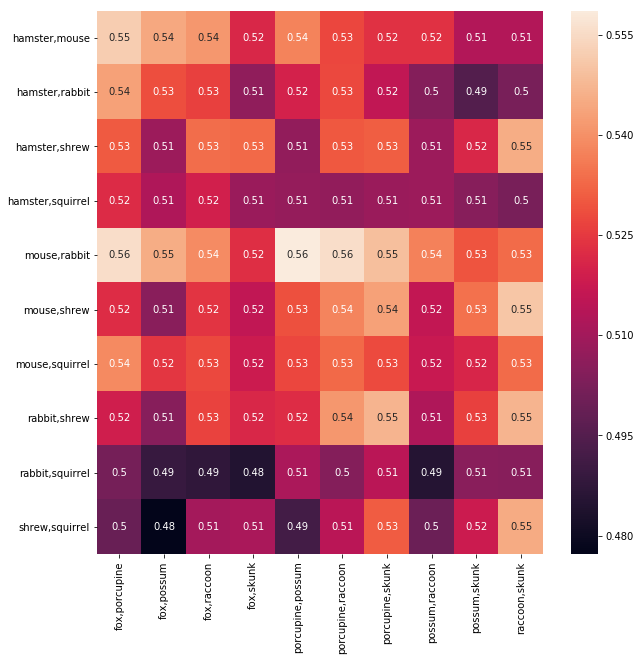

In [0]:
#cm=confusion_matrix(y_test_bin_1, bag_pred, labels=[0,1], sample_weight=None)
plt.figure(figsize = (10,10))
data=pd.DataFrame([knn_accuracy3[0:10],knn_accuracy3[10:20],knn_accuracy3[20:30],knn_accuracy3[30:40],knn_accuracy3[40:50],knn_accuracy3[50:60],knn_accuracy3[60:70],knn_accuracy3[70:80],knn_accuracy3[80:90],knn_accuracy3[90:100]],
                  index = [small_two[i][0]+','+small_two[i][1] for i in range(0,10)],
                  columns = [medium_two[i][0]+','+medium_two[i][1] for i in range(0,10)])


ax=sns.heatmap(data, annot=True)


In [0]:
pd.DataFrame(knn_accuracy3).describe()

,0
count,100.000000
mean,0.521469
std,0.017263
min,0.477222
25%,0.508819
50%,0.521667
75%,0.533125
max,0.558611


# **Bagging**

In [0]:
# find the baseline performance for the bagging
start = time.time()
bag = BaggingClassifier()
bag.fit(x_remaining_mammals, y_remaining_mammals_bin)
bag_pred=bag.predict(x_rest_mammals)
scores = cross_val_score(bag, x_remaining_mammals,y_remaining_mammals_bin, cv=5)
print(scores)
scores = cross_val_score(bag, x_rest_mammals,y_rest_mammals_bin, cv=5)
print(scores)
print ("Bagging Accuracy: {}%".format(bag.score(x_remaining_mammals, y_remaining_mammals_bin)*100))
print ("Bagging Accuracy: {}%".format(bag.score(x_rest_mammals, y_rest_mammals_bin)*100))
end = time.time()
print(end - start)

[0.70416667 0.70625    0.75       0.70625    0.69166667]
[0.6375     0.64861111 0.6625     0.64027778 0.64444444]
Bagging Accuracy: 99.0%
Bagging Accuracy: 50.16666666666667%
557.3837399482727


## **finding the best peremeter**

In [0]:
for a in [1,2,3]:
  for b in [0.001,0.01]:
    for c in [True,False]:
      for d in [True,False]:
        print('n_estimators: {}, max_sample: {}, bootstrap: {}, bootstrap_features: {}'.format(a,b,c,d))
        bag_clf = BaggingClassifier(n_estimators=a, max_samples=b, bootstrap=c, bootstrap_features=d)
        bag_clf.fit(x_remaining_mammals, y_remaining_mammals_bin)
        scores = cross_val_score(bag_clf, x_remaining_mammals,y_remaining_mammals_bin, cv=5)
        print(scores)
        print ("Bagging Accuracy: {}%".format(bag_clf.score(x_rest_mammals, y_rest_mammals_bin)*100))

n_estimators: 1, max_sample: 0.001, bootstrap: True, bootstrap_features: True
[0.5 0.5 0.5 0.5 0.5]
Bagging Accuracy: 47.77777777777778%
n_estimators: 1, max_sample: 0.001, bootstrap: True, bootstrap_features: False
[0.5 0.5 0.5 0.5 0.5]
Bagging Accuracy: 47.44444444444444%
n_estimators: 1, max_sample: 0.001, bootstrap: False, bootstrap_features: True
[0.5 0.5 0.5 0.5 0.5]
Bagging Accuracy: 51.47222222222222%
n_estimators: 1, max_sample: 0.001, bootstrap: False, bootstrap_features: False
[0.5 0.5 0.5 0.5 0.5]
Bagging Accuracy: 49.083333333333336%
n_estimators: 1, max_sample: 0.01, bootstrap: True, bootstrap_features: True
[0.6125     0.64583333 0.60416667 0.55833333 0.5125    ]
Bagging Accuracy: 52.94444444444445%
n_estimators: 1, max_sample: 0.01, bootstrap: True, bootstrap_features: False
[0.55833333 0.57083333 0.61666667 0.58333333 0.57708333]
Bagging Accuracy: 48.583333333333336%
n_estimators: 1, max_sample: 0.01, bootstrap: False, bootstrap_features: True
[0.46666667 0.55       0.

In [0]:
for a in [4,5,10]:
  for b in [0.001,0.01]:
    for c in [True,False]:
      for d in [True,False]:
        print('n_estimators: {}, max_sample: {}, bootstrap: {}, bootstrap_features: {}'.format(a,b,c,d))
        bag_clf = BaggingClassifier(n_estimators=a, max_samples=b, bootstrap=c, bootstrap_features=d)
        bag_clf.fit(x_remaining_mammals, y_remaining_mammals_bin)
        scores = cross_val_score(bag_clf, x_remaining_mammals,y_remaining_mammals_bin, cv=5)
        print(scores)
        print ("Bagging Accuracy: {}%".format(bag_clf.score(x_rest_mammals, y_rest_mammals_bin)*100))

n_estimators: 4, max_sample: 0.001, bootstrap: True, bootstrap_features: True
[0.5 0.5 0.5 0.5 0.5]
Bagging Accuracy: 49.25%
n_estimators: 4, max_sample: 0.001, bootstrap: True, bootstrap_features: False
[0.5 0.5 0.5 0.5 0.5]
Bagging Accuracy: 50.74999999999999%
n_estimators: 4, max_sample: 0.001, bootstrap: False, bootstrap_features: True
[0.5 0.5 0.5 0.5 0.5]
Bagging Accuracy: 49.69444444444445%
n_estimators: 4, max_sample: 0.001, bootstrap: False, bootstrap_features: False
[0.5 0.5 0.5 0.5 0.5]
Bagging Accuracy: 53.333333333333336%
n_estimators: 4, max_sample: 0.01, bootstrap: True, bootstrap_features: True
[0.61458333 0.62083333 0.64166667 0.63958333 0.55625   ]
Bagging Accuracy: 48.91666666666667%
n_estimators: 4, max_sample: 0.01, bootstrap: True, bootstrap_features: False
[0.6625     0.59791667 0.63125    0.63333333 0.6375    ]
Bagging Accuracy: 50.94444444444445%
n_estimators: 4, max_sample: 0.01, bootstrap: False, bootstrap_features: True
[0.59791667 0.56041667 0.67708333 0.63

In [0]:
for a in [100,500,1000]:
  for b in [0.001,0.01]:
    for c in [True,False]:
      for d in [True,False]:
        print('n_estimators: {}, max_sample: {}, bootstrap: {}, bootstrap_features: {}'.format(a,b,c,d))
        bag_clf = BaggingClassifier(n_estimators=a, max_samples=b, bootstrap=c, bootstrap_features=d)
        bag_clf.fit(x_remaining_mammals, y_remaining_mammals_bin)
        scores = cross_val_score(bag_clf, x_remaining_mammals,y_remaining_mammals_bin, cv=5)
        print(scores)
        print ("Bagging Accuracy: {}%".format(bag_clf.score(x_rest_mammals, y_rest_mammals_bin)*100))

n_estimators: 100, max_sample: 0.001, bootstrap: True, bootstrap_features: True
[0.5 0.5 0.5 0.5 0.5]
Bagging Accuracy: 52.47222222222222%
n_estimators: 100, max_sample: 0.001, bootstrap: True, bootstrap_features: False
[0.5 0.5 0.5 0.5 0.5]
Bagging Accuracy: 50.05555555555555%
n_estimators: 100, max_sample: 0.001, bootstrap: False, bootstrap_features: True
[0.5 0.5 0.5 0.5 0.5]
Bagging Accuracy: 50.027777777777786%
n_estimators: 100, max_sample: 0.001, bootstrap: False, bootstrap_features: False
[0.5 0.5 0.5 0.5 0.5]
Bagging Accuracy: 50.55555555555556%
n_estimators: 100, max_sample: 0.01, bootstrap: True, bootstrap_features: True
[0.69583333 0.70208333 0.70833333 0.71041667 0.69166667]
Bagging Accuracy: 53.61111111111111%
n_estimators: 100, max_sample: 0.01, bootstrap: True, bootstrap_features: False
[0.68333333 0.70625    0.7        0.72916667 0.70208333]
Bagging Accuracy: 53.27777777777778%
n_estimators: 100, max_sample: 0.01, bootstrap: False, bootstrap_features: True
[0.69375    

In [0]:
for a in [1,10,100]:
  for b in [0.1,1]:
    for c in [True,False]:
      for d in [True,False]:
        print('n_estimators: {}, max_sample: {}, bootstrap: {}, bootstrap_features: {}'.format(a,b,c,d))
        bag_clf = BaggingClassifier(n_estimators=a, max_samples=b, bootstrap=c, bootstrap_features=d)
        bag_clf.fit(x_remaining_mammals, y_remaining_mammals_bin)
        scores = cross_val_score(bag_clf, x_remaining_mammals,y_remaining_mammals_bin, cv=5)
        print(scores)
        print ("Bagging Accuracy: {}%".format(bag_clf.score(x_rest_mammals, y_rest_mammals_bin)*100))

n_estimators: 1, max_sample: 0.1, bootstrap: True, bootstrap_features: True
[0.62708333 0.60833333 0.575      0.60833333 0.57916667]
Bagging Accuracy: 48.66666666666667%
n_estimators: 1, max_sample: 0.1, bootstrap: True, bootstrap_features: False
[0.61041667 0.59791667 0.63333333 0.61041667 0.66458333]
Bagging Accuracy: 49.888888888888886%
n_estimators: 1, max_sample: 0.1, bootstrap: False, bootstrap_features: True
[0.54583333 0.61666667 0.63125    0.58958333 0.58541667]
Bagging Accuracy: 47.27777777777778%
n_estimators: 1, max_sample: 0.1, bootstrap: False, bootstrap_features: False
[0.61041667 0.59375    0.64583333 0.6        0.625     ]
Bagging Accuracy: 51.63888888888889%
n_estimators: 1, max_sample: 1, bootstrap: True, bootstrap_features: True
[0.5 0.5 0.5 0.5 0.5]
Bagging Accuracy: 50.0%
n_estimators: 1, max_sample: 1, bootstrap: True, bootstrap_features: False
[0.5 0.5 0.5 0.5 0.5]
Bagging Accuracy: 50.0%
n_estimators: 1, max_sample: 1, bootstrap: False, bootstrap_features: True

## **train by the best peremeter**

In [0]:
# find the baseline performance for the bagging
start = time.time()
bag = BaggingClassifier(n_estimators = 3, max_samples = 0.01, bootstrap = True, bootstrap_features = False)
bag.fit(x_remaining_mammals, y_remaining_mammals_bin)
bag_pred=bag.predict(x_rest_mammals)
scores = cross_val_score(bag, x_remaining_mammals,y_remaining_mammals, cv=5)
print(scores)
scores = cross_val_score(bag, x_rest_mammals,y_rest_mammals_bin, cv=5)
print(scores)
print ("Bagging Accuracy: {}%".format(bag.score(x_remaining_mammals, y_remaining_mammals_bin)*100))
print ("Bagging Accuracy: {}%".format(bag.score(x_rest_mammals, y_rest_mammals_bin)*100))
end = time.time()
print(end - start)

[0.33541667 0.35416667 0.35625    0.35416667 0.26666667]
[0.53194444 0.53055556 0.52222222 0.525      0.54583333]
Bagging Accuracy: 62.0%
Bagging Accuracy: 52.0%
3.4020745754241943


In [0]:
indices = [np.random.choice(range(len(x_rest_mammals))) for i in range(36)]

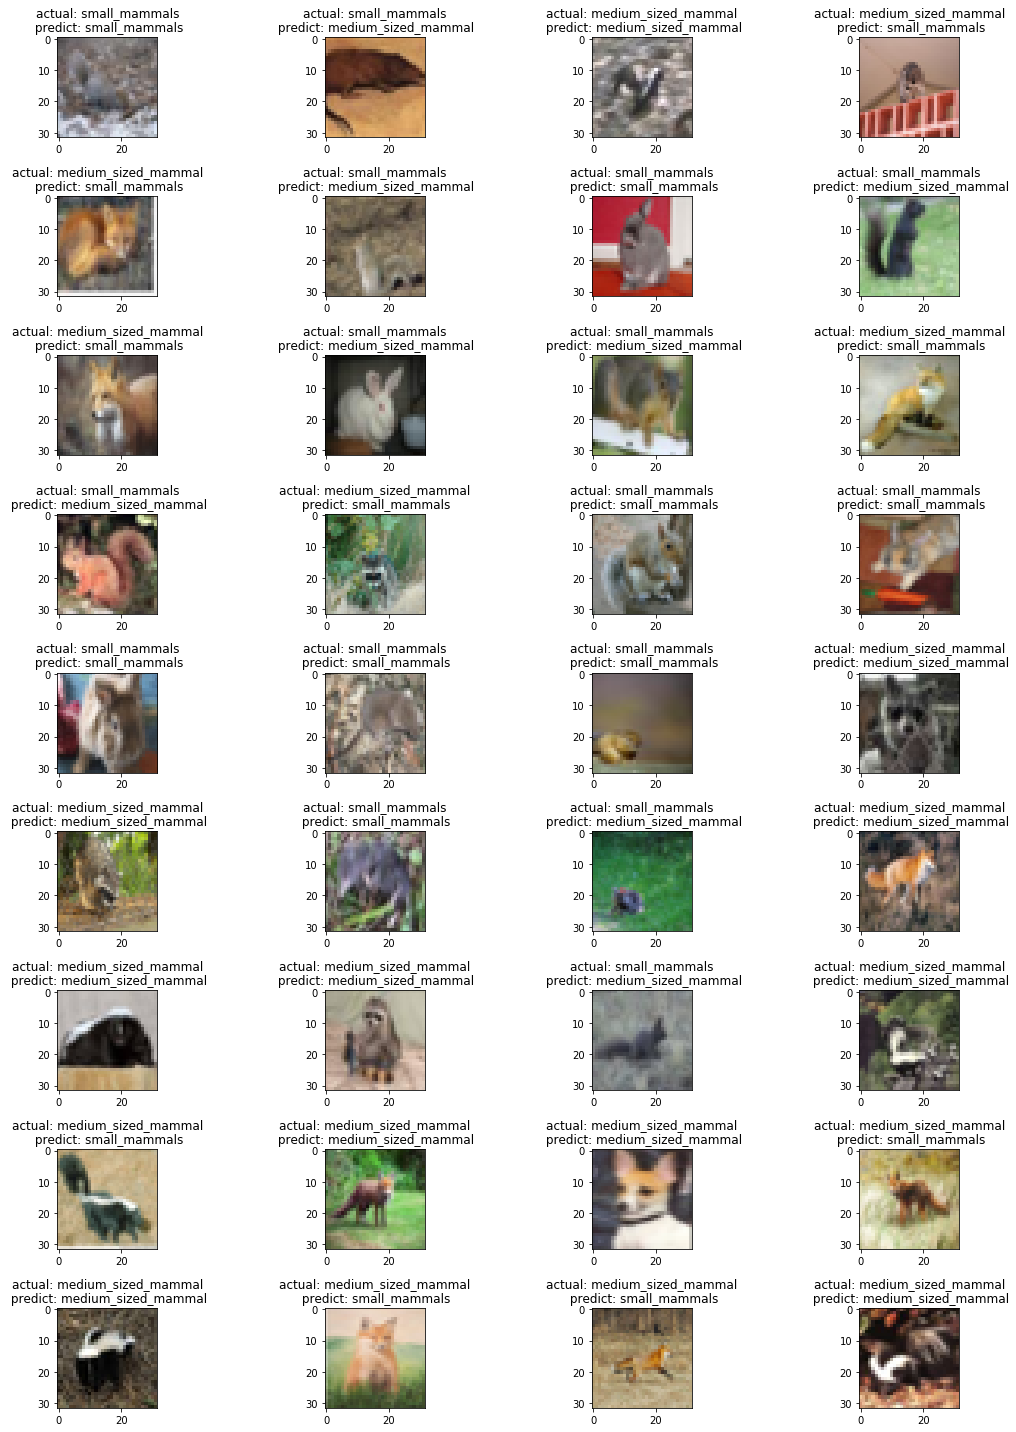

In [0]:
cifar_grid2(x_rest_mammals,y_rest_mammals_bin,indices,4,bag_pred)

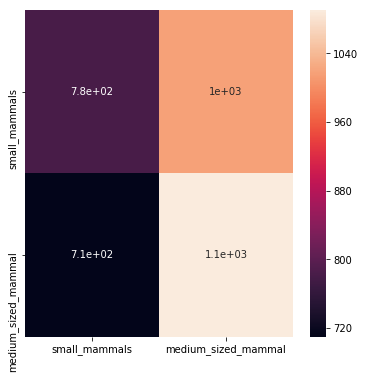

In [0]:
cm=confusion_matrix(y_rest_mammals_bin, bag_pred, labels=[0,1], sample_weight=None)
plt.figure(figsize = (6,6))
df_cm = pd.DataFrame(cm, index = [i for i in ['small_mammals','medium_sized_mammal']],
                  columns = [i for i in ['small_mammals','medium_sized_mammal']])

ax=sns.heatmap(df_cm, annot=True)

In [0]:
print(classification_report(y_rest_mammals_bin, bag_pred,target_names=['small_mammals','medium_sized_mammal']))

                     precision    recall  f1-score   support

      small_mammals       0.52      0.43      0.48      1800
medium_sized_mammal       0.52      0.61      0.56      1800

          micro avg       0.52      0.52      0.52      3600
          macro avg       0.52      0.52      0.52      3600
       weighted avg       0.52      0.52      0.52      3600



# **Bagging loop**

In [0]:
bag_accuracy3=list()
bag_time3=list()
print("bagging") 
for i in range(0,100):
  start = time.time()
  bag1 = BaggingClassifier(n_estimators = 3, max_samples = 0.01, bootstrap = True, bootstrap_features = False)
  bag1.fit(x_train5_[i], y_train_bin5[i])
  bag1_pred=bag1.predict(x_test5_[i])
  print ("Accuracy ({}, {}): {}%".format(train_list[i][0],train_list[i][1] ,bag1.score(x_test5_[i], y_test_bin5[i])*100)) 
  end = time.time()
  print('{} seconds\n'.format(end - start))
  bag_accuracy3.append(bag1.score(x_test5_[i], y_test_bin5[i]))
  bag_time3.append(end-start)
  # choose 36 img randomly
  #indices = [np.random.choice(range(len(x_test3_[i]))) for j in range(36)]
  #cifar_grid1(x_test3_[i], y_test_bin3[i], indices,4,lr_pred)
print("average accuracy: {}%".format(np.mean(bag_accuracy3)*100))
print("average time: {} seconds".format(np.mean(bag_time3)))

bagging
Accuracy (['hamster', 'mouse'], ['fox', 'porcupine']): 53.05555555555556%
0.9114084243774414 seconds

Accuracy (['hamster', 'mouse'], ['fox', 'possum']): 53.52777777777777%
0.8942050933837891 seconds

Accuracy (['hamster', 'mouse'], ['fox', 'raccoon']): 53.05555555555556%
0.8976011276245117 seconds

Accuracy (['hamster', 'mouse'], ['fox', 'skunk']): 54.58333333333333%
0.8882052898406982 seconds

Accuracy (['hamster', 'mouse'], ['porcupine', 'possum']): 49.72222222222222%
0.8954215049743652 seconds

Accuracy (['hamster', 'mouse'], ['porcupine', 'raccoon']): 50.55555555555556%
0.9146230220794678 seconds

Accuracy (['hamster', 'mouse'], ['porcupine', 'skunk']): 47.94444444444444%
0.8914644718170166 seconds

Accuracy (['hamster', 'mouse'], ['possum', 'raccoon']): 51.388888888888886%
0.8810286521911621 seconds

Accuracy (['hamster', 'mouse'], ['possum', 'skunk']): 51.52777777777777%
0.8861021995544434 seconds

Accuracy (['hamster', 'mouse'], ['raccoon', 'skunk']): 48.61111111111111%

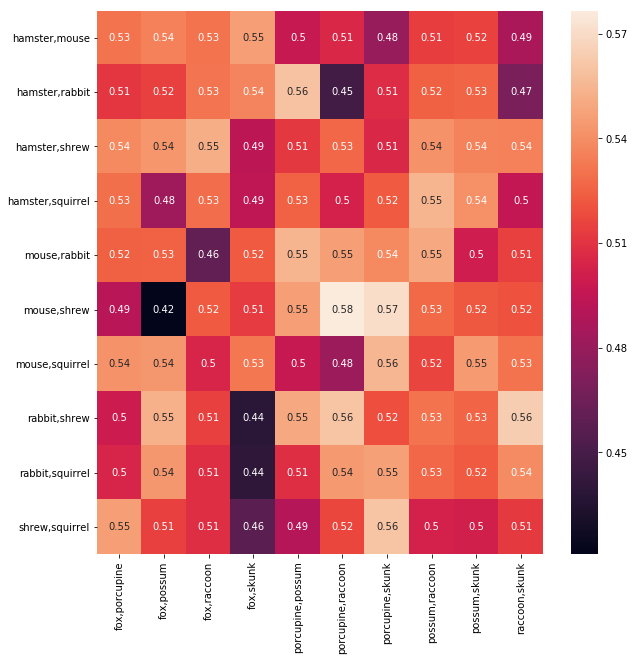

In [0]:
#cm=confusion_matrix(y_test_bin_1, bag_pred, labels=[0,1], sample_weight=None)
plt.figure(figsize = (10,10))
data=pd.DataFrame([bag_accuracy3[0:10],bag_accuracy3[10:20],bag_accuracy3[20:30],bag_accuracy3[30:40],bag_accuracy3[40:50],bag_accuracy3[50:60],bag_accuracy3[60:70],bag_accuracy3[70:80],bag_accuracy3[80:90],bag_accuracy3[90:100]],
                  index = [small_two[i][0]+','+small_two[i][1] for i in range(0,10)],
                  columns = [medium_two[i][0]+','+medium_two[i][1] for i in range(0,10)])


ax=sns.heatmap(data, annot=True)

In [0]:
pd.DataFrame(bag_accuracy3, columns=['Bagging missing 3 pairs']).describe()

,Bagging missing 3 pairs
count,100.000000
mean,0.519750
std,0.028999
min,0.420833
25%,0.505347
50%,0.523611
75%,0.541181
max,0.576667


#CNN (Qiao Liu)

In [1]:
# create list for train and test
# train,test=test,train
x_train5=list()
x_test5=list()
y_train_bin5=list()
y_test_bin5=list()
train_list=list()  
for i in range(0,10):
  for j in range(0,10):
    small=small_two[i]
    medium=medium_two[j]
    x_test_temp,x_train_temp,y_test_temp,y_train_temp=train_test_2(small,medium)
    x_train5.append(x_train_temp)
    x_test5.append(x_test_temp)
    y_train_bin5.append(y_train_temp)
    y_test_bin5.append(y_test_temp)
    train_list.append([small,medium])  


NameError: ignored

In [0]:
#connect to my google drive 
from google.colab import drive
from keras.models import load_model
drive.mount('/content/gdrive')

In [0]:
#Load saved model
model = load_model('/content/gdrive/My Drive/my_model4.h5')

In [0]:
#loop through all 100 pairs 
#the CNN will be initialized for each pair
for i in range(0,100):
  model = load_model('/content/gdrive/My Drive/my_model4.h5')
  lr = 0.0001
  opt = Adam(lr=lr, decay=1e-6)

  model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
  
  x_train = x_train5[i]
  x_test = x_test5[i]
  y_train_bin_c = to_categorical(y_train_bin5[i])
  y_test_bin_c = to_categorical(y_test_bin5[i])

  hist= model.fit(x_train, y_train_bin_c,validation_data=(x_test, y_test_bin_c), epochs=15)
  scores = model.evaluate(x_test, y_test_bin_c, verbose=0)
  
  print("trial ", i, " result: score: %.2f%%" % (scores[1]*100))

In [0]:
#pick a set and run it again for further analysis
i = 19
model = load_model('/content/gdrive/My Drive/my_model4.h5')
lr = 0.0001
opt = Adam(lr=lr, decay=1e-6)

model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
  
x_train = x_train5[i]
x_test = x_test5[i]
y_train_bin_c = to_categorical(y_train_bin5[i])
y_test_bin_c = to_categorical(y_test_bin5[i])

hist= model.fit(x_train, y_train_bin_c,validation_data=(x_test, y_test_bin_c), epochs=20)
scores = model.evaluate(x_test, y_test_bin_c, verbose=0)
  
print("trial ", i, " result: score: %.2f%%" % (scores[1]*100))

In [0]:
#function to plot model accuracy and loss
def plot_model_history(model_history):
   fig, axs = plt.subplots(1,2,figsize=(15,5))
   # summarize history for accuracy
   axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
   axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
   axs[0].set_title('Model Accuracy')
   axs[0].set_ylabel('Accuracy')
   axs[0].set_xlabel('Epoch')
   axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
   axs[0].legend(['train', 'test'], loc='best')
   # summarize history for loss
   axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
   axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
   axs[1].set_title('Model Loss')
   axs[1].set_ylabel('Loss')
   axs[1].set_xlabel('Epoch')
   axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
   axs[1].legend(['train', 'test'], loc='best')
   plt.show()

In [0]:
#plot training and testing loss
plot_model_history(hist)

In [0]:
y_predict = model.predict(x_test)
y_pred = np.argmax(y_predict, axis=1)

In [0]:
#Generate confusion matrix
from sklearn.metrics import confusion_matrix
import pandas as pd
confusion_df = pd.DataFrame(confusion_matrix(np.argmax(y_test_bin_c, axis=1), y_pred),
                           columns=["Predicted Class " + str(class_name) for class_name in ['Small Mammals', 'Medium sized Mammals']],
                           index = ['Class ' + str(class_name) for class_name in ['Small Mammals', 'Medium sized Mammals']])
print(confusion_df)

In [0]:
#Generate classification report
from sklearn.metrics import classification_report
target_names = ['Small Mammals', 'Medium sized Mammals']
print(classification_report(np.argmax(y_test_bin_c, axis = 1), y_pred, target_names=target_names))

In [0]:
#function for printing randomly selected images with labels and the prediction result
#Unmatched predictions will be colored red
def cifar_grid2(X,Y,inds,n_col,predictions):  #print out randomly selected images and their labels  
  N = len(inds)
  n_row = int(ceil(1.0*N/n_col))
  fig = plt.figure(figsize=(15, 20))
# align labels in the right order  #encode the target class
  clabels = ['small_mammals','medium_mammals']
  #print(type(clabels))
  for j in range(n_row):
    for k in range(n_col):
      i_inds = (j*n_col)+k
      i_data = inds[i_inds]
     
      if i_inds < N:
        rgb = X[[i_data,...]] 
        label =clabels[Y[i_data][0]]
        img = rgb.reshape(3,32,32).transpose([1, 2, 0])
        fig.add_subplot(n_row,n_col, i_inds+1)
        pred = clabels[predictions[i_data]]
        plt.imshow(img, interpolation='nearest')
        title_obj = plt.title("actual: {}\n predict: {}".format(label,pred))
        if label != pred:
          plt.setp(title_obj, color='r') 
        else:
          plt.setp(title_obj, color='k') 
         
  fig.set_tight_layout(True)

In [0]:
#Generate the random images vs. prediction
indices = [np.random.choice(range(len(x_rest_mammals))) for j in range(36)]
cifar_grid2(x_rest_mammals, y_rest_mammals_bin, indices,6,y_pred)